# Link prediction with GCN

In this notebook we consider the task of predicting the relationships between longevity-related phenotypes and individual genes. The problem is treated as a supervised link prediction on a homogeneous network with nodes representing both phenotypes and genes and links corresponding to either relations between the two, or between two different genes.

The goal of this notebook is to showcase the classification process on a single cross-validation fold. For the final experiment with all folds refer to the `gcn-link-prediction-cv.ipynb` notebook.

The information about the node type is encoded into its features: each node has a one-hot feature vector of size `len(phenotypes) + 1` assigned, with i-th element of the vector being set to 1 if the node describes i-th phenotype, and the last element being set to 1 if the node describes any of the genes.

The model used is a 4-layer GCN that takes labeled node pairs corresponding to possible gene-to-phenotype links, and outputs a pair of node embeddings for the nodes of the pair. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings to construct the embedding of the potential link. Thus obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network.

Based on the GCN link prediction example from StellarGraph (https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html).

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import stellargraph as sg
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from tensorflow import keras
from tqdm.keras import TqdmCallback

from graph import load_splits

## Loading the data

We aim to train a link prediction model, hence we need to prepare the train and test sets of links and the corresponding graphs with those links removed.

We are going to split our input graph into a train and test graphs manually, since 1) `EdgeSplitter` class from StellarGraph wasn't able to handle splitting the dataset, likely due to the nature of the network (the fact that removing the existing edges would have to disconnect the graph), 2) the fact that since the total number of possible gene-to-phenotype connections is small enough we will want to consider all possible edges at the test time, and 3) since we want to perform a cross-validation.

We will use the train graph for training the model (a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not) and the test graph for evaluating the model's performance on hold out data. Each of these graphs will have the same number of nodes as the input graph, but the number of links will differ (be reduced) as some of the links will be removed during each split and used as the positive samples for training/testing the link prediction classifier.

The code responsible for splitting the data can be found in `graph.py`. Overall, the splitting procedure is as follows:
- Generate all possible gene-to-phenotype edges, and label them as positive if they exist in the provided graph, and negative otherwise.
- Using k-fold cross-validation split the edges into k seperate folds (we will consider k = 5 in the conducted experiments), that is the collection of train and test edges.
- Reduce the G_test graph by removing the positive edges. This graph, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.
- From the reduced graph G_test, extract a randomly sampled subset of train edges (true and false gene-to-phenotype links) and the reduced graph G_train with the positive train edges removed. G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Note that in the procedure we focus on the gene-to-phenotype edges and completely ignore the gene-to-gene edges, which are also present and provide a backbone for the graph.

In [2]:
(G_train, edge_ids_train, edge_labels_train), (G_test, edge_ids_test, edge_labels_test) = load_splits(sample_test_negatives=False)[0]

print("Train graph:")
print(f"\t# of sampled edges: {len(edge_ids_train)}.")
print(f"\tLabel distribution: {Counter(edge_labels_train)}.")
print(G_train.info())

print("-----")

print("Test graph:")
print(f"\t# of sampled edges: {len(edge_ids_test)}.")
print(f"\tLabel distribution: {Counter(edge_labels_test)}.")
print(G_test.info())

Train graph:
	# of sampled edges: 3216.
	Label distribution: Counter({1: 1608, 0: 1608}).
StellarGraph: Undirected multigraph
 Nodes: 9836, Edges: 49090

 Node types:
  default: [9836]
    Features: float32 vector, length 73
    Edge types: default-default->default

 Edge types:
    default-default->default: [49090]
        Weights: all 1 (default)
        Features: none
-----
Test graph:
	# of sampled edges: 140602.
	Label distribution: Counter({0: 138593, 1: 2009}).
StellarGraph: Undirected multigraph
 Nodes: 9836, Edges: 50698

 Node types:
  default: [9836]
    Features: float32 vector, length 73
    Edge types: default-default->default

 Edge types:
    default-default->default: [50698]
        Weights: all 1 (default)
        Features: none


## Creating the GCN link model

Next, we create the link generators for the train and test link examples to the model. The link generators take the pairs of nodes (`gene`, `phenotype`) that are given in the `.flow` method to the Keras model, together with the corresponding binary labels indicating whether those pairs represent true or false links.

The number of epochs for training the model:

In [3]:
epochs = 5000

For training we create a generator on the `G_train` graph, and make an iterator over the training links using the generator's `flow()` method:

In [4]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [5]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


We create a GCN model as follows:

In [6]:
gcn = GCN(
    layer_sizes=[256, 256, 256, 256], activations=["relu", "relu", "relu", "relu"], generator=train_gen, dropout=0.25
)

To create a Keras model we now expose the input and output tensors of the GCN model for link prediction, via the `GCN.in_out_tensors` method:

In [7]:
x_inp, x_out = gcn.in_out_tensors()

Final link classification layer that takes a pair of node embeddings produced by the GCN model, applies a binary operator to them to produce the corresponding inner product link embedding, and passes it through a dense layer. Since the inner product of two embeddings passed through a ReLU activation in the previous layers is always non-negative, we will use tanh activation to keep the outputs in 0-1 range:

In [8]:
# prediction = LinkEmbedding(activation=keras.layers.ReLU(max_value=1.0), method="ip")(x_out)
prediction = LinkEmbedding(activation="tanh", method="ip")(x_out)

The predictions need to be reshaped from `(X, 1)` to `(X,)` to match the shape of the targets we have supplied above.

In [9]:
prediction = keras.layers.Reshape((-1,))(prediction)

Stack the GCN and prediction layers into a Keras model, and specify the loss

In [10]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.binary_crossentropy,
    metrics=[
        keras.metrics.BinaryAccuracy(), 
        keras.metrics.Precision(), 
        keras.metrics.Recall(),
        keras.metrics.AUC()
    ],
)

Evaluate the initial (untrained) model on the train and test set. Note that the test dataset is heavily imbalanced (since all of the negative edges were considered), so standard metrics (accuracy, AUC) are skewed.

In [11]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 75ms/step - loss: 0.1536 - binary_accuracy: 0.9712 - precision: 0.1233 - recall: 0.1667 - auc: 0.8738

Train Set Metrics of the initial (untrained) model:
	loss: 0.7235
	binary_accuracy: 0.5861
	precision: 0.9425
	recall: 0.1835
	auc: 0.8659

Test Set Metrics of the initial (untrained) model:
	loss: 0.1536
	binary_accuracy: 0.9712
	precision: 0.1233
	recall: 0.1667
	auc: 0.8738


## Training & evaluation

Train the model:

In [12]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, 
    verbose=0, callbacks=[TqdmCallback(verbose=1)], shuffle=True
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Plot the training history:

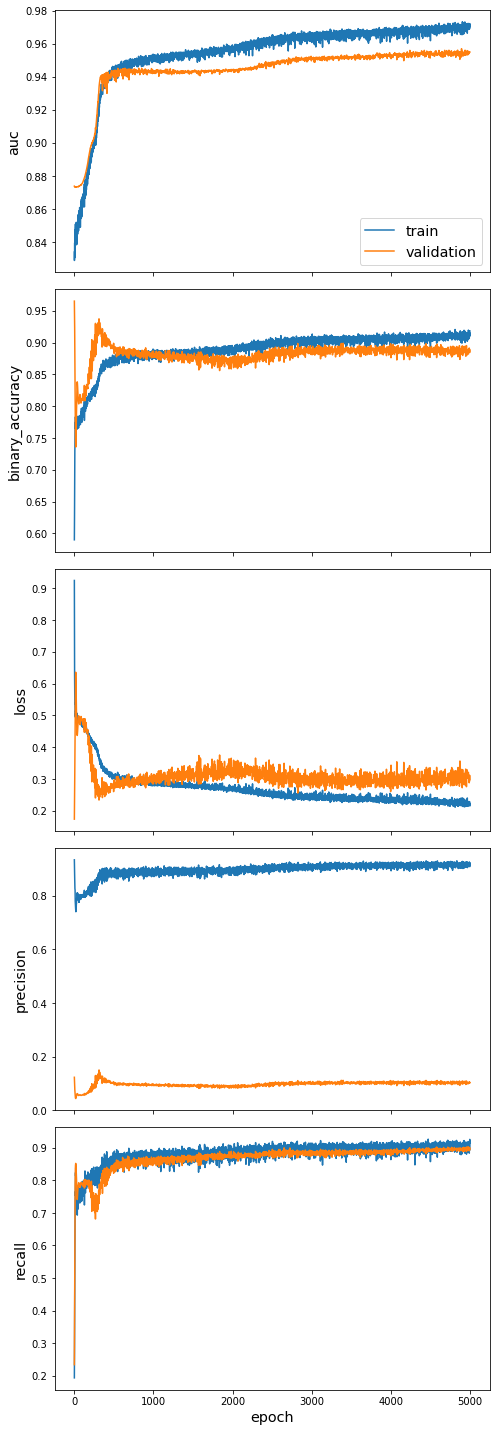

In [13]:
sg.utils.plot_history(history)

Evaluate the trained model on test links:

In [14]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 80ms/step - loss: 0.2974 - binary_accuracy: 0.8884 - precision: 0.1040 - recall: 0.8945 - auc: 0.9550

Train Set Metrics of the trained model:
	loss: 0.2504
	binary_accuracy: 0.9027
	precision: 0.9080
	recall: 0.8961
	auc: 0.9630

Test Set Metrics of the trained model:
	loss: 0.2974
	binary_accuracy: 0.8884
	precision: 0.1040
	recall: 0.8945
	auc: 0.9550


Repeat the evaluation using sklearn (since Keras doesn't provide all of the metrics):

In [15]:
y_test = test_flow[0][-1][0]
y_prob = model.predict(test_flow)[0]
y_pred = (y_prob > 0.5).astype(int)

In [16]:
{
    'Acc': np.round(accuracy_score(y_test, y_pred), 4),
    'BAC': np.round(balanced_accuracy_score(y_test, y_pred), 4),
    'Precision': np.round(precision_score(y_test, y_pred), 4),
    'Recall': np.round(recall_score(y_test, y_pred), 4),
    'PR-AUC': np.round(average_precision_score(y_test, y_prob), 4),
    'AUC': np.round(roc_auc_score(y_test, y_prob), 4),
}

{'Acc': 0.8884,
 'BAC': 0.8914,
 'Precision': 0.104,
 'Recall': 0.8945,
 'PR-AUC': 0.4863,
 'AUC': 0.9561}

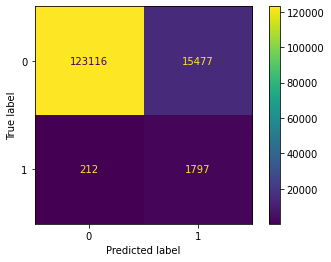

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Export edge predictions as a pandas DataFrame:

In [18]:
rows = []

for edge, p in zip(test_flow[0][0][1][0], y_prob):
    phn, gen = edge
    rows.append([G_test.nodes()[gen], G_test.nodes()[phn], p])

df = pd.DataFrame(rows, columns=["Gen", "Phn", "p"])
df

,Gen,Phn,p
0,SLC9A1,D1071,0.987561
1,MAGI3,D1071,0.895405
2,S100A14,D1071,0.765053
3,C1orf35,D1071,0.825456
4,SUPT7L,D1071,0.997255
...,...,...,...
140597,SFT2D3,D1222,0.001582
140598,PLEKHH1,D1222,0.000688
140599,ALOX15B,D1222,0.000000
140600,TNFSF15,D1222,0.000000
